# Introduction

This notebook will illustrate experiments with the Adam optimizer in TensorFlow to solve the `lagaris_05` 2-D PDE BVP.

## The `lagaris05` PDE problem

This PDE was used as the fifth example problem in (Lagaris *et al.*, 1998). The differential equation is provided in the form (equation (32) in Lagaris *et al.* (1998)):

\begin{equation}
    \nabla^2 \psi (x,y) = e^{-x} \left( x - 2 + y^3 + 6y \right)
\end{equation}

or:

\begin{equation}
    G \left( x, y, \psi, \frac {\partial \psi} {dx}, \frac {\partial \psi} {\partial y}, \frac {\partial^2 \psi} {dx^2} \frac {\partial^2 \psi} {\partial y^2} \right) = \frac {\partial^2 \psi} {\partial x^2} + \frac {\partial^2 \psi} {dy^2} - e^{-x} \left( x - 2 + y^3 + 6y \right) = 0
\end{equation}

with initial conditions:

\begin{equation}
    f_0(0, y) = \psi(0, y) = y^3 \\
    f_1(1, y) = \psi(1, y) = ( 1 + y^3 ) e^{-1} \\
    g_0(x, 0) = \psi(x, 0) = x e^{-x} \\
    g_1(x, 1) = \psi(x, 1) = e^{-x} (x + 1)
\end{equation}

The analytical solution is:

\begin{equation}
    \psi_a(x, y) = e^{-x} (x + y^3)
\end{equation}

The derivatives are:

\begin{equation}
    \frac {\partial \psi} {\partial x} = e^{-x} ( 1 - x - y^3) \\
    \frac {\partial \psi} {\partial y} = 3 e^{-x} y^2 \\
    \frac {\partial^2 \psi} {\partial x^2} = e^{-x} ( -2 + x + y^3) \\
    \frac {\partial^2 \psi} {\partial y^2} = 6 e^{-x} y
\end{equation}

The analytical solution in the domain $0 \leq x,y \leq 1$ is plotted below.

In [1]:
# Import standard Python modules.
import datetime
import importlib
from math import exp
import os
import platform
import sys

# Import 3rd-party modules.
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Import TensorFlow.
import tensorflow as tf

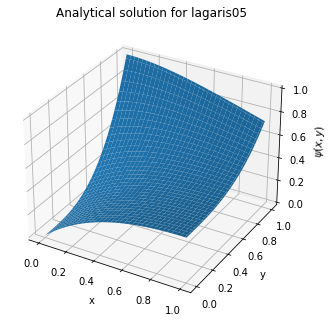

In [2]:
# Import the problem definition.
eq_name = "lagaris05"
eq_module = 'nnde.differentialequation.examples.lagaris_05'
eq = importlib.import_module(eq_module)

# Compute the analytical solution.
# Note that Y is used in place of \psi in the code.
na = 101
xa = np.linspace(0, 1, na)
ya = np.linspace(0, 1, na)
Ya = [[eq.Ya([x, y]) for y in ya] for x in xa]
Ya = np.array(Ya)

# Plot the analytical solution.
fig = plt.figure()
(X, Y) = np.meshgrid(xa, ya)
Z = Ya.T
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\psi(x,y)$')
plt.title("Analytical solution for %s" % eq_name)
plt.show()

## Solving `lagaris05` using TensorFlow

In [3]:
def print_system_information():
    print("System report:")
    print(datetime.datetime.now())
    print("Host name: %s" % platform.node())
    print("OS: %s" % platform.platform())
    print("uname:", platform.uname())
    print("Python version: %s" % sys.version)
    print("Python build:", platform.python_build())
    print("Python compiler: %s" % platform.python_compiler())
    print("Python implementation: %s" % platform.python_implementation())
    # print("Python file: %s" % __file__)

In [4]:
def create_output_directory(path=None):
    path_noext, ext = os.path.splitext(path)
    output_dir = path_noext
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    return output_dir

In [5]:
from nnde.math.trainingdata import create_training_grid2

def create_training_data(*n_train):
    x_train = np.array(create_training_grid2(*n_train))
    return x_train

In [6]:
def build_model(H, w0_range, u0_range, v0_range):
    hidden_layer = tf.keras.layers.Dense(
        units=H, use_bias=True,
        activation=tf.keras.activations.sigmoid,
        kernel_initializer=tf.keras.initializers.RandomUniform(*w0_range),
        bias_initializer=tf.keras.initializers.RandomUniform(*u0_range)
    )
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.RandomUniform(*v0_range),
        use_bias=False,
    )
    model = tf.keras.Sequential([hidden_layer, output_layer])
    return model

In [7]:
print_system_information()

System report:
2021-10-23 11:15:46.080604
Host name: C02DT5CZMD6T-ML
OS: macOS-10.16-x86_64-i386-64bit
uname: uname_result(system='Darwin', node='C02DT5CZMD6T-ML', release='20.6.0', version='Darwin Kernel Version 20.6.0: Mon Aug 30 06:12:21 PDT 2021; root:xnu-7195.141.6~3/RELEASE_X86_64', machine='x86_64', processor='i386')
Python version: 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]
Python build: ('default', 'Aug  6 2021 08:56:27')
Python compiler: Clang 10.0.0 
Python implementation: CPython


In [51]:
# Define the hyperparameters.

# Set up the output directory.
path = "./lagaris_05_tf_adam"
output_dir = create_output_directory(path)

# Training optimizer
training_algorithm = "Adam"

# Initial parameter ranges
w0_range = [-0.1, 0.1]
u0_range = [-0.1, 0.1]
v0_range = [-0.1, 0.1]

# Number of hidden nodes.
H = 10

# Number of training points in each dimension.
nx_train = 11
ny_train = 11
n_train = nx_train*ny_train

# Number of training epochs.
n_epochs = 100000

# Learning rate.
learning_rate = 0.01

# Random number generator seed.
random_seed = 0

In [52]:
# Create and save the training data.
xy_train = create_training_data(nx_train, ny_train)
x_train = xy_train[::ny_train, 0]
y_train = xy_train[:ny_train, 1]
np.savetxt(os.path.join(output_dir,'xy_train.dat'), xy_train)

In [53]:
# Build the model.
model = build_model(H, w0_range, u0_range, v0_range)

# Create the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [54]:
# Train the model.

# Create history variables.
losses = []
phist = []

# Set the random number seed for reproducibility.
tf.random.set_seed(random_seed)

# Rename the training data Variable (_v) for convenience, just for training.
xy_train_v = tf.Variable(xy_train, dtype=tf.float32, name="xy_train")
xy = xy_train_v

print("Hyperparameters: n_train = %s, H = %s, n_epochs = %s, learning_rate = %s"
      % (n_train, H, n_epochs, learning_rate))
t_start = datetime.datetime.now()
print("Training started at", t_start)

for epoch in range(n_epochs):
    if epoch % 1000 == 0:
        print("Starting epoch %d." % epoch)

    # Run the forward pass.
    with tf.GradientTape(persistent=True) as tape3:
        with tf.GradientTape(persistent=True) as tape2:
            with tf.GradientTape(persistent=True) as tape1:

                # Extract individual coordinates and watch them.
                x = xy[:, 0]
                y = xy[:, 1]

                # Compute the network output.
                N = model(xy)

                # Compute the trial solution.
                # NOTE:
                # This is (corrected) Eq. 23 in Lagaris, 1998.
                # The original equation has a - in front of the last term,
                # which is wrong.
                A = (
                    (1 - x)*y**3
                    + x*(1 + y**3)*tf.math.exp(-1.0)
                    + (1 - y)*x*(tf.math.exp(-x) - tf.math.exp(-1.0))
                    + y*(tf.math.exp(-x)*(x + 1) - (1 - x + 2*x*tf.math.exp(-1.0)))
                )
                P = x*(1 - x)*y*(1 - y)
                Y = A + P*N[:, 0]

            # Compute the gradient of the trial solution wrt inputs.
            dY_dx = tape1.gradient(Y, x)
            dY_dy = tape1.gradient(Y, y)

        # Compute the Laplacian of trial solution wrt inputs.
        d2Y_dx2 = tape2.gradient(dY_dx, x)
        d2Y_dy2 = tape2.gradient(dY_dy, y)

        # Compute the estimates of the differential equations.
        G = d2Y_dx2 + d2Y_dy2 - tf.math.exp(-x)*(x - 2 + y**3 + 6*y)

        # Compute the loss function.
        L = tf.math.sqrt(tf.reduce_sum(G**2)/n_train)

    # Save the current losses.
    losses.append(L.numpy())

    # Compute the gradient of the loss function wrt the network parameters.
    pgrad = tape3.gradient(L, model.trainable_variables)

    # Save the parameters used in this pass.
    phist.append(
        np.hstack(
            (model.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
             model.trainable_variables[1].numpy(),       # u (H,) row vector
             model.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
        )
    )

    # Update the parameters for this pass.
    optimizer.apply_gradients(zip(pgrad, model.trainable_variables))

    
# Save the parameters used in the last pass.
phist.append(
    np.hstack(
        (model.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
         model.trainable_variables[1].numpy(),       # u (H,) row vector
         model.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
    )
)

t_stop = datetime.datetime.now()
print("Training stopped at", t_stop)
t_elapsed = t_stop - t_start
print("Total training time was %s seconds." % t_elapsed.total_seconds())

# # Save the parameter histories.
np.savetxt(os.path.join(output_dir, 'phist.dat'), np.array(phist))

Hyperparameters: n_train = 121, H = 10, n_epochs = 100000, learning_rate = 0.01
Training started at 2021-10-23 12:13:04.379409
Starting epoch 0.
Starting epoch 1000.
Starting epoch 2000.
Starting epoch 3000.
Starting epoch 4000.
Starting epoch 5000.
Starting epoch 6000.
Starting epoch 7000.
Starting epoch 8000.
Starting epoch 9000.
Starting epoch 10000.
Starting epoch 11000.
Starting epoch 12000.
Starting epoch 13000.
Starting epoch 14000.
Starting epoch 15000.
Starting epoch 16000.
Starting epoch 17000.
Starting epoch 18000.
Starting epoch 19000.
Starting epoch 20000.
Starting epoch 21000.
Starting epoch 22000.
Starting epoch 23000.
Starting epoch 24000.
Starting epoch 25000.
Starting epoch 26000.
Starting epoch 27000.
Starting epoch 28000.
Starting epoch 29000.
Starting epoch 30000.
Starting epoch 31000.
Starting epoch 32000.
Starting epoch 33000.
Starting epoch 34000.
Starting epoch 35000.
Starting epoch 36000.
Starting epoch 37000.
Starting epoch 38000.
Starting epoch 39000.
Starti

In [55]:
# Compute and save the trained results at training points.
with tf.GradientTape(persistent=True) as tape2:
    with tf.GradientTape(persistent=True) as tape1:
        x = xy[:, 0]
        y = xy[:, 1]
        N = model(xy)
        A = (
            (1 - x)*y**3
            + x*(1 + y**3)*tf.math.exp(-1.0)
            + (1 - y)*x*(tf.math.exp(-x) - tf.math.exp(-1.0))
            + y*(tf.math.exp(-x)*(x + 1) - (1 - x + 2*x*tf.math.exp(-1.0)))
        )
        P = x*(1 - x)*y*(1 - y)
        # Solution.
        Yt_train = A + P*N[:, 0]
    # First partial derivatives.
    dYt_dx_train = tape1.gradient(Yt_train, x)
    dYt_dy_train = tape1.gradient(Yt_train, y)
# Second partial derivatives.
d2Yt_dx2_train = tape2.gradient(dYt_dx_train, x)
d2Yt_dy2_train = tape2.gradient(dYt_dy_train, y)
np.savetxt(os.path.join(output_dir, 'Yt_train.dat'), Yt_train.numpy().reshape((n_train)))
np.savetxt(os.path.join(output_dir, 'dYt_dx_train.dat'), dYt_dx_train.numpy())
np.savetxt(os.path.join(output_dir, 'dYt_dy_train.dat'), dYt_dy_train.numpy())
np.savetxt(os.path.join(output_dir, 'd2Yt_dx2_train.dat'), d2Yt_dx2_train.numpy())
np.savetxt(os.path.join(output_dir, 'd2Yt_dy2_train.dat'), d2Yt_dy2_train.numpy())

# Compute and save the analytical solution and derivative at training points.
# Solution.
Ya_train = np.array([eq.Ya(xy) for xy in xy_train])
np.savetxt(os.path.join(output_dir,'Ya_train.dat'), Ya_train)
# First partial derivatives.
dYa_dx_train = np.array([eq.dYa_dx(xy) for xy in xy_train])
dYa_dy_train = np.array([eq.dYa_dy(xy) for xy in xy_train])
np.savetxt(os.path.join(output_dir,'dYa_dx_train.dat'), dYa_dx_train)
np.savetxt(os.path.join(output_dir,'dYa_dy_train.dat'), dYa_dy_train)
# Second partial derivatives.
d2Ya_dx2_train = np.array([eq.d2Ya_dx2(xy) for xy in xy_train])
d2Ya_dy2_train = np.array([eq.d2Ya_dy2(xy) for xy in xy_train])
np.savetxt(os.path.join(output_dir,'d2Ya_dx2_train.dat'), d2Ya_dx2_train)
np.savetxt(os.path.join(output_dir,'d2Ya_dy2_train.dat'), d2Ya_dy2_train)

# Compute and save the error in the trained solution and derivatives at training points.
Yt_err_train = Yt_train.numpy() - Ya_train
np.savetxt(os.path.join(output_dir, 'Yt_err_train.dat'), Yt_err_train)
dYt_dx_err_train = dYt_dx_train.numpy() - dYa_dx_train
dYt_dy_err_train = dYt_dx_train.numpy() - dYa_dy_train
np.savetxt(os.path.join(output_dir, 'dYt_dx_err_train.dat'), dYt_dx_err_train)
np.savetxt(os.path.join(output_dir, 'dYt_dy_err_train.dat'), dYt_dy_err_train)
d2Yt_dx2_err_train = d2Yt_dx2_train.numpy() - d2Ya_dx2_train
d2Yt_dy2_err_train = d2Yt_dx2_train.numpy() - d2Ya_dy2_train
np.savetxt(os.path.join(output_dir, 'd2Yt_dx2_err_train.dat'), d2Yt_dx2_err_train)
np.savetxt(os.path.join(output_dir, 'd2Yt_dy2_err_train.dat'), d2Yt_dy2_err_train)

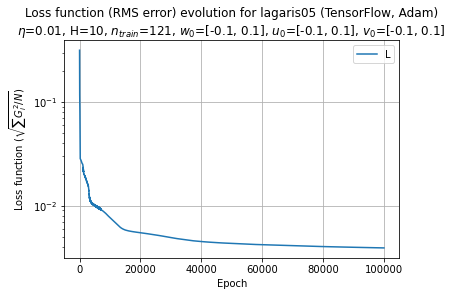

In [56]:
# Plot the loss function history.
plt.semilogy(losses, label="L")
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sqrt {\sum G_i^2/N}$)")
plt.grid()
plt.legend()
plt.title("Loss function (RMS error) evolution for %s (%s, %s)\n$\eta$=%s, H=%s, $n_{train}$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TensorFlow', training_algorithm, learning_rate, H, n_train, w0_range, u0_range, v0_range))
plt.show()

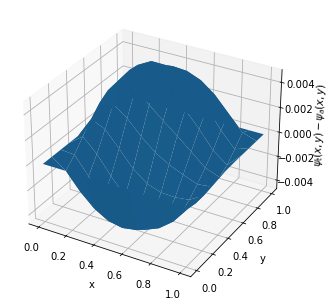

In [57]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = Yt_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained solution at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\psi_t(x,y)-\psi_a(x,y)$')
plt.show()

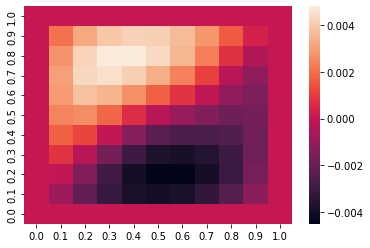

In [58]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(Yt_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

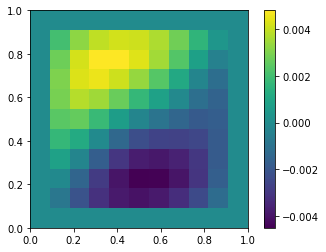

In [59]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(Yt_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

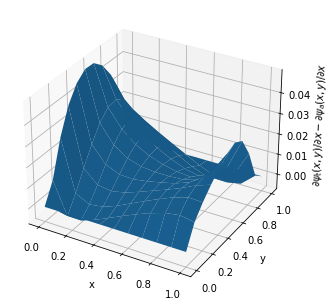

In [60]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = dYt_dx_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained 1st x-derivative at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\partial \psi_t(x,y)/\partial x-\partial \psi_a(x,y)/\partial x$')
plt.show()

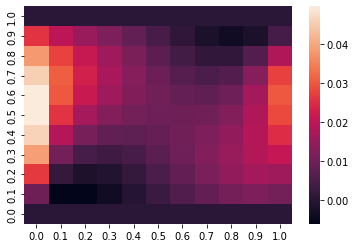

In [61]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(dYt_dx_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

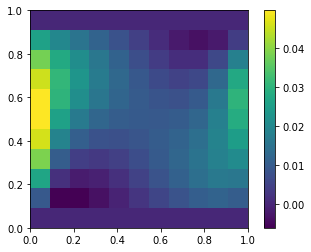

In [62]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(dYt_dx_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

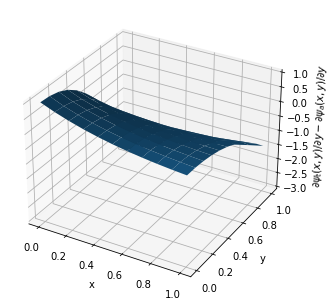

In [63]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = dYt_dy_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained 1st y-derivative at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\partial \psi_t(x,y)/\partial y-\partial \psi_a(x,y)/\partial y$')
plt.show()

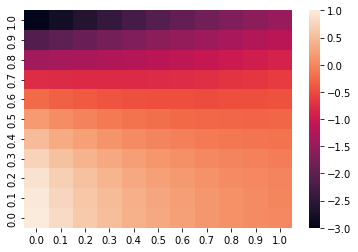

In [64]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(dYt_dy_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

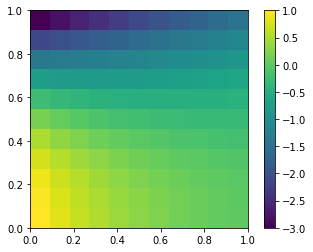

In [65]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(dYt_dy_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

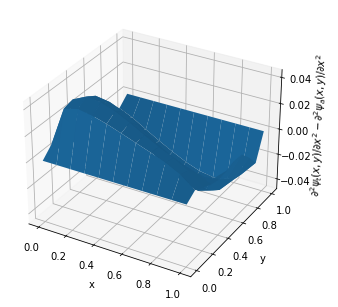

In [66]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = d2Yt_dx2_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained 2nd x-derivative at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\partial^2 \psi_t(x,y)/\partial x^2-\partial^2 \psi_a(x,y)/\partial x^2$')
plt.show()

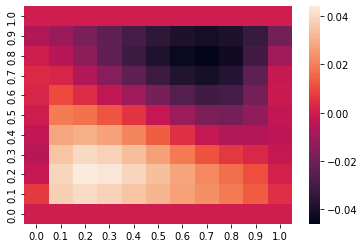

In [67]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(d2Yt_dx2_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

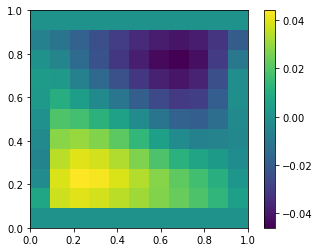

In [68]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(d2Yt_dx2_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

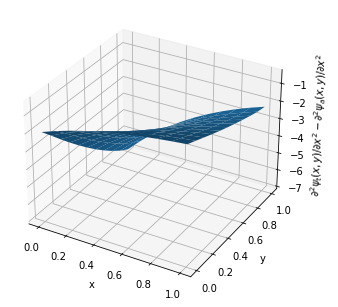

In [69]:
# For surface plotting, reshape as (n_x, n_y), then transpose.
Z = d2Yt_dy2_err_train.reshape((nx_train, ny_train)).T

# Plot the error in the trained 2nd y-derivative at the training points.
fig = plt.figure()
(X, Y) = np.meshgrid(x_train, y_train)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\partial^2 \psi_t(x,y)/\partial x^2-\partial^2 \psi_a(x,y)/\partial x^2$')
plt.show()

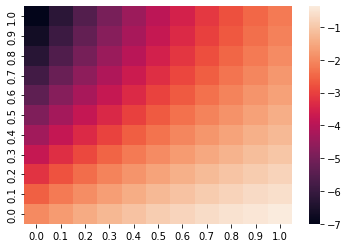

In [70]:
# For a Seaborn heat map, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(d2Yt_dy2_err_train.reshape((nx_train, ny_train)).T, axis=0)
ax = sns.heatmap(Z, xticklabels=x_train, yticklabels=np.flip(y_train))

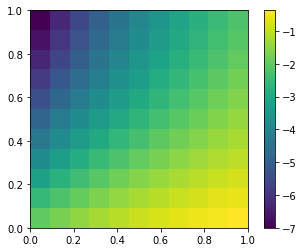

In [71]:
# For a Matplotlib imshow plot, reshape as (n_x, n_y), then transpose, then flip.
Z = np.flip(d2Yt_dy2_err_train.reshape((nx_train, ny_train)).T, axis=0)
fig, ax = plt.subplots(1, 1)
values = ax.imshow(Z, extent=(0, 1, 0, 1))
fig.colorbar(values)
plt.show()

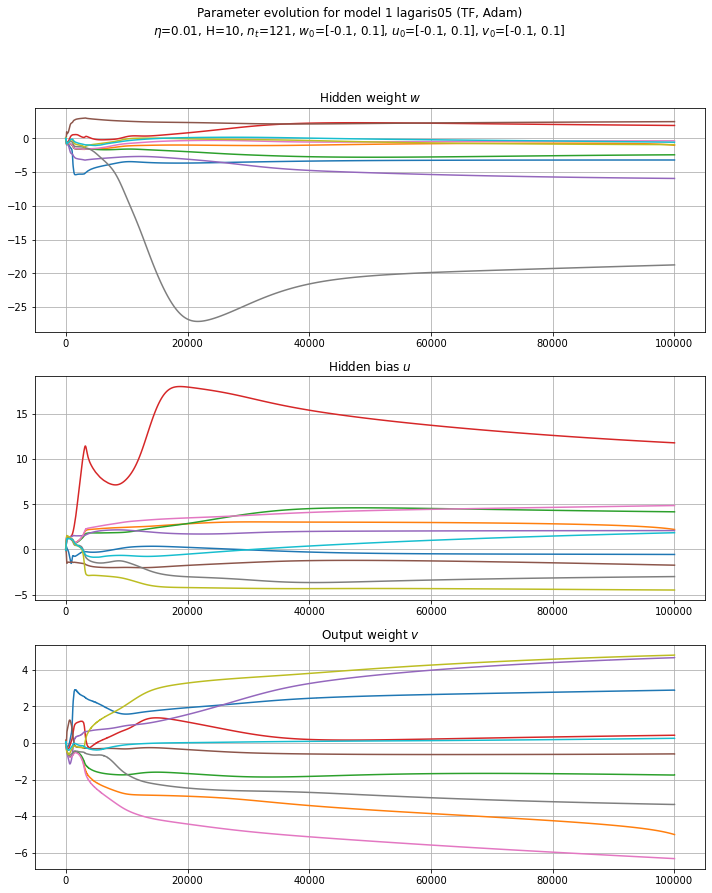

In [72]:
# Plot the parameter histories for model 1.
phist = np.array(phist)
plt.figure(figsize=(12, 14))

# w
plt.subplot(311)
plt.plot(phist[:, 0:H])
plt.title("Hidden weight $w$")
plt.grid()

# u
plt.subplot(312)
plt.plot(phist[:, H:2*H])
plt.title("Hidden bias $u$")
plt.grid()

# v
plt.subplot(313)
plt.plot(phist[:, 2*H:3*H])
plt.title("Output weight $v$")
plt.grid()

plt.suptitle("Parameter evolution for model 1 %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TF', training_algorithm, learning_rate, H, n_train, w0_range, u0_range, v0_range))
plt.subplots_adjust(hspace=0.2)
plt.show()